In [2]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

# Chapter 3. Sampling



$$Pr(vampire|positive) = \frac{Pr(positive|vampire) Pr(vampire)} {Pr(positive)}$$

$$Pr(positive) = Pr(positive|vampire) * (Pr(vampire) + Pr(positive|mortal)) * (1 − Pr(vampire))$$

In [3]:
PrPV = 0.95
PrPM = 0.01
PrV = 0.001
PrP = PrPV * PrV + PrPM * (1 - PrV)
PrVP = PrPV * PrV / PrP
PrVP

0.08683729433272395

The way that we have computed $Pr(Vampire|positive)$ is arbitrarily complicated; humans do not think in "probabilities." We instead think in counts (i.e., frequencies).


If we rephrased the problem as:

* There are 100 vampires in a population of 100,000.

* 95 of those 100 vampires will test positive for vampirism.

* 999 of the 99,900 non-vampires will test positive for vampirism.

Thus $Pr(Vampire|positive) = 95 / 1094 = 0.087$.


Just as it is easier to think about counts for these types of problems, we will leverage counts to solve more complex Bayesian problems. For example, we can sample observations from the probability distributions to obtain counts. This has two other advantages:

* We can avoid doing integral calculus. Instead of integrating over an interval of a probability distribution, we just add up the counts.

* MCMC methods produce only samples, and not probability distributions. Thus it is important to be able to conceptualize and process samples from the posterior in order to fit these models.







***

## 3.1 Sampling from a grid-approximate posterior


In order to get used to sampling we are going to sample from the globe-tossing model. This is an extremely simple problem and we could actually compute the exact probabilities, but we will sample from the posterior as an exercise.

In [4]:
def posterior_grid_approx(grid, success=6, tosses=9):
    """
    """

    # define prior
    prior = np.repeat(5, len(p_grid))  # uniform
    #prior = (p_grid >= 0.5).astype(int)  # truncated
    #prior = np.exp(- 5 * abs(p_grid - 0.5))  # double exp

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    grid_posterior = unstd_posterior / unstd_posterior.sum()
    return grid_posterior

In [5]:
# define grid
p_grid = np.linspace(0, 1, 100)

# Compute posterior via grid approximation
grid_posterior = posterior_grid_approx(grid=p_grid, success=6, tosses=9)

# Randomly sample 10,000 times from the posterior with replacement
sample_posterior = np.random.choice(p_grid, p=grid_posterior, size=int(10000), replace=True)

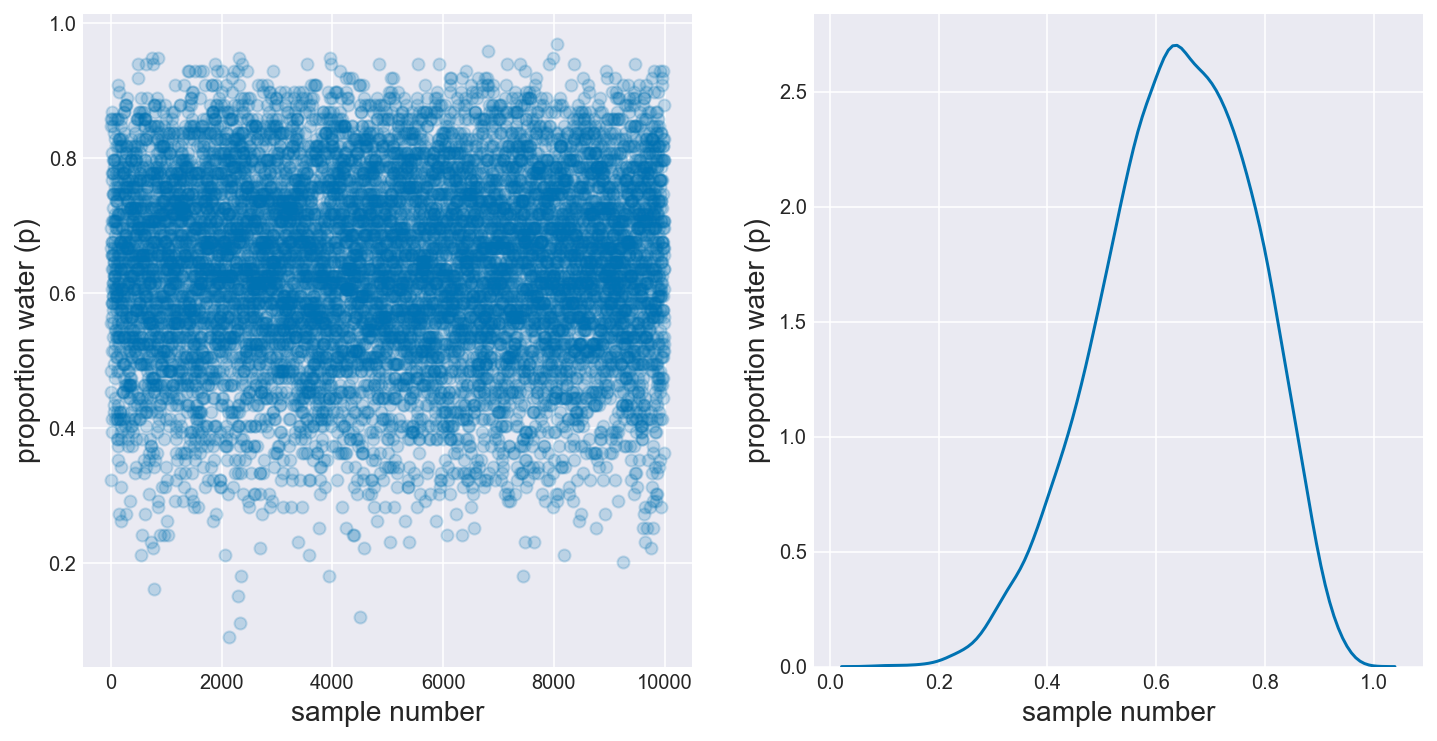

In [6]:
# Plot of each of the 10,000 samples ("aerial view")
_, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6))
ax0.plot(sample_posterior, 'o', alpha=0.2)
ax0.set_xlabel('sample number', fontsize=14)
ax0.set_ylabel('proportion water (p)', fontsize=14)

# Kernel density plot of each of the 10,000 samples
sns.kdeplot(sample_posterior, ax=ax1)
ax1.set_xlabel('sample number', fontsize=14)
ax1.set_ylabel('proportion water (p)', fontsize=14);

***

So far all we've done is replicate the posterior distribution that we had already calculated by grid approximation. The usefulness of this new approximated posterior is that we can use it to describe and understand the posterior.

***

# 3.2 Sampling to summarize

Once the model produces a posterior, its work is done; but your work has just begun. You must summarize and interpret your posterir. Exactly how you summarize it depends on what you are interested in, but some common questions may look like this:

* What proportion of observations (i.e., probability) fall within this interval of parameter values? *(questions about interval defined boundaries)*

* What parameter value has the highest posterior probability? *(questions about point estimates)*

* What range of parameter values contains \_\_% of the posterior probability? *(questions about intervals of defined probability mass)*

### 3.2.1 Intervals of defined boundaries

**Example.** What is the p.p. that the proportion of water is less than 0.5?

Using our grid-approximated posterior we can easily calculate this:

In [7]:
# Sum of all probabilities where p is less than 0.5
np.sum(grid_posterior[p_grid < 0.5])

0.17183313110747478

However, we won't always have these exact values. Let's try using our samples:

In [8]:
np.sum(sample_posterior < 0.5) / len(sample_posterior)

0.166

### 3.2.2 Intervals of defined mass

This is more commonly seen in the literature. The frequentist equivalent is the *confidence interval*. An interval of p.p. is more specifically referred to as a *credible interval*.

**Example.** What parameter range contains the bottom 80% of the probability mass?

In [9]:
np.percentile(sample_posterior, [80])

array([0.76767677])

In [10]:
# We can also answer questions about intervals:
np.percentile(sample_posterior, [10, 90])

array([0.45454545, 0.81818182])

The type of interval we computed in the cell block above is called a **percentile interval**. It is very common in the literature and does a good job of communicating the shape of the distribution, as long as the distribution is not too asymmetrical.

Consider instead a very asymmetrical posterior:

In [11]:
grid_posterior_asymmetric = posterior_grid_approx(grid=p_grid, success=3, tosses=3)

Text(0,0.5,'density')

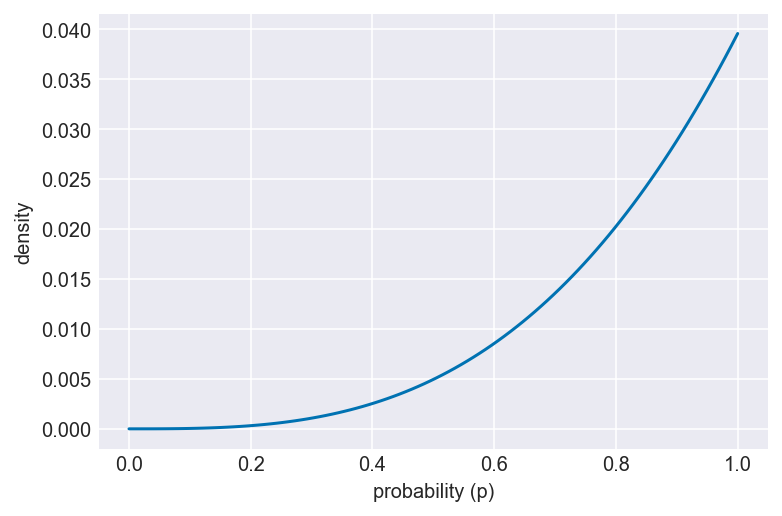

In [12]:
plt.plot(p_grid, grid_posterior_asymmetric)
plt.xlabel('probability (p)')
plt.ylabel('density')

If we were to compute a percentile interval for this distribution, what would be the best way to do it? There are infinite ways to compute a percentile interval.

A second type of interval is useful for this, the **highest posterior density interval** (HDPI). The HDPI is the narrowest interval that contains the specified probability mass; this interval is a better interval for communicating the nature of the data. Though in the end, it is often best to simply **plot the entire posterior distribution**. 

In [13]:
# Sample from the asymmetric posterior
sample_posterior_asymmetric = np.random.choice(p_grid, p=grid_posterior_asymmetric, size=int(1e4), replace=True)

# A 50% percentile interval equivalent to the interquartile range. Note that this is not a good way to communicate the data.
np.percentile(sample_posterior_asymmetric, [25, 75])

array([0.71717172, 0.93939394])

In [14]:
# A better way to communicate the data, using the HDPI
pm.hpd(sample_posterior_asymmetric, alpha=0.5)

array([0.82828283, 0.98989899])

### 3.2.3 Point estimates

The Bayesian parameter estimate *is* the entire posterior distribution, which is not a single number, but instead a function that maps each unique parameter value onto a plausibility value. In short, you will never have to choose a single point estimate to represent your distribution.

If you do decide to report a single number, you will have to consider several other questions. What is the **loss** that you are trying to minimize?

If you are trying to minimize the absolute deviation, you might select the median. If you are trying to minimize the squared deviation, you might select the mean. If the distribution is symmetrical and approximately normal, then these two values will converge.

However, the choice of loss funciton should depend on the question you are ultimately trying to answer. Loss functions are often conventionalized, but that doesn't mean that the conventional choice is always (or even often) the best choice. For example, imagine deciding if an evacuation order is necessary for a hurricane. Damage caused by a hurricane increases rapidly with wind speed; there is also the cost of ordering an evacuation when none is needed, but these costs may not be as large.


## 3.3 Sampling to simulate prediction

Sampling from the posterior also makes **simulation** easier. Simulation is useful for a number of reasons.

**1. Model checking.** After a model is fit to real data, it is worth simulating the implied observations to see if the model behaved corretly and to investigate the behaviour of the model.

**2. Software validation.** We can simulate the observations under a known model and see if it produces good estimates of the model parameters. This will indicate to us if the software producing the model are working correctly.

**3. Research Design.** If you can simulate observations from your null hypothesis, then you can evaluate your research design. For example, you can conduct a power analysis; though the possibilities are much broader.

**4. Forecasting.** You can use your estimates to simulate new predictions. This can either be for novel prediction or to test the accuracy of your current model.

***

### 3.3.1. Dummy data

When we are fitting a model, we use the likelihood function to figure out how likely the observed data are. We can use the likelihood function in the reverse order to simulate **dummy data**--simulated data that stand in for actual data.

We modeled the globe-tossing example with the binomial likelihood. Instead of asking "what is the probability of observing 6 waters out of 9?",  we can  turn around and ask "what are the most plausible outcomes if we flipped 9 times when p=0.7?"

In [15]:
# A simple example; possibilities out of 3 tosses:
stats.binom.pmf(k = range(3), n = 2, p = 0.7)

array([0.09, 0.42, 0.49])

Text(0,0.5,'Probability')

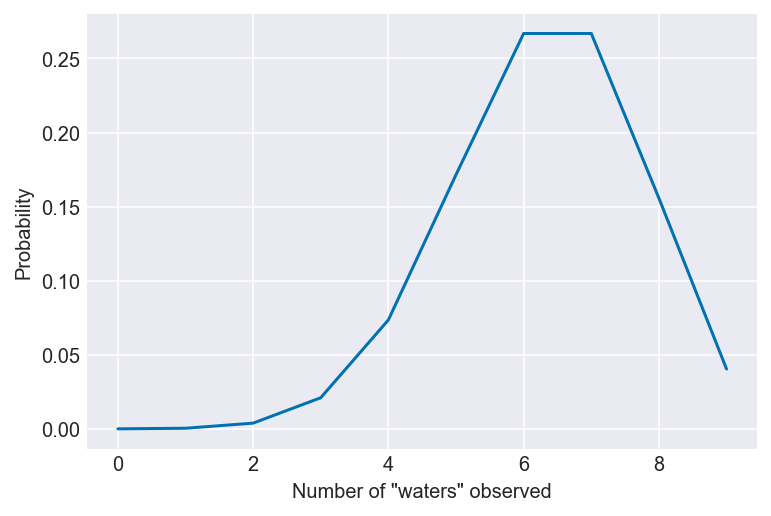

In [17]:
# Possibilities out of 9 tosses:
x = stats.binom.pmf(k = range(10), n = 9, p = 0.7)

plt.plot(x)
plt.xlabel('Number of "waters" observed')
plt.ylabel('Probability')

In the code cells above, we've computed the probabilities of observing each case, but to make dummy data we'll simulate actual observations:

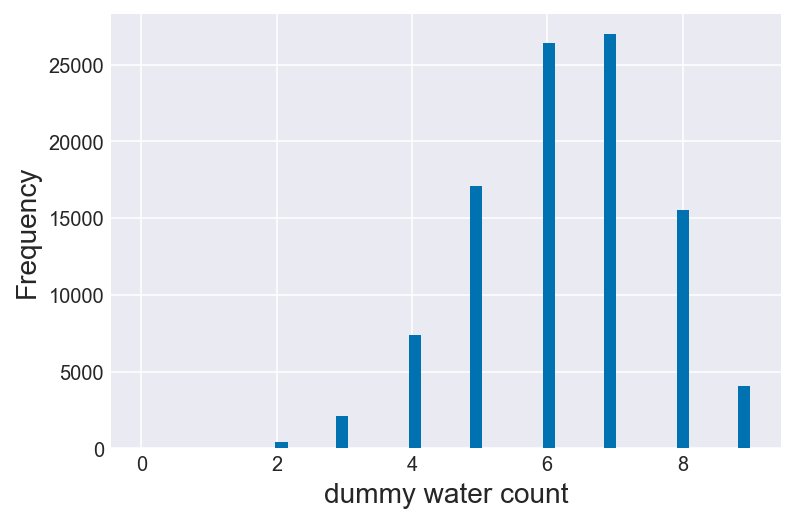

In [18]:
# stats.binom.rvs produces random samples, just like how rbinom does in R
# Some different values to play with, commented out.
dummy_w = stats.binom.rvs(n=9, p=0.7, size=int(1e5))
#dummy_w = stats.binom.rvs(n=9, p=0.6, size=int(1e4))
#dummy_w = stats.binom.rvs(n=9, p=sample_posterior)

plt.hist(dummy_w, bins=50)
plt.xlabel('dummy water count', fontsize=14)
plt.ylabel('Frequency', fontsize=14);

***

# Exercises

***

## Easy.

Easy. These problems use the samples from the posterior distribution for the globe tossing example. This code will give you a specifc set of samples, so that you can check your answers exactly.

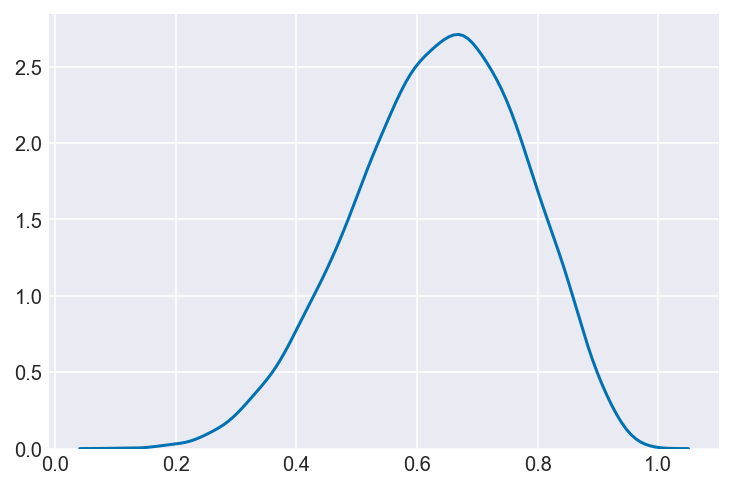

In [40]:
grid_posterior = posterior_grid_approx(p_grid, success=6, tosses=9)
np.random.seed(100)
sample_posterior = np.random.choice(p_grid, p=grid_posterior, size=int(1e4), replace=True)

sns.kdeplot(sample_posterior)

**3E1.** How much posterior probability lies below p = 0.2?

In [43]:
# Count number of observations below 0.2 and divide by total number of observations
np.sum(sample_posterior < 0.2) / len(sample_posterior)

0.0009

**3E2.** How much posterior probability lies below p = 0.8?

In [45]:
np.sum(sample_posterior < 0.8) / len(sample_posterior)

0.8831

**3E3.** How much posterior probability lies between 0.2 and 0.8?

In [46]:
np.sum(sample_posterior < 0.8) / len(sample_posterior) - np.sum(sample_posterior < 0.2) / len(sample_posterior)

0.8822

**3E4.** 20% of the posterior probability lies below which value of p?

In [55]:
# Find value that corresponds to the 20th percentile
np.percentile(sample_posterior, [20])

array([0.51515152])

**3E5.** 20% of the posterior probability above below which value of p?

In [53]:
np.percentile(sample_posterior, [80])

array([0.75757576])

**3E6.** Which values of p contain the narrowest interval equal to 66% of the posterior probability?

In [57]:
# Highest probability density (interval) from PyMC3
pm.hpd(sample_posterior, alpha = 0.66)

array([0.56565657, 0.68686869])

**3E7.** Which values of p contain 66% of the posterior probability, assuming equal posterior probability both below and above the interval?

In [61]:
np.percentile(sample_posterior, [33.3/2, 100 - 33.3/2])

array([0.49494949, 0.77777778])

#### Code 3.28

In [25]:
birth1 = np.array([1,0,0,0,1,1,0,1,0,1,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,0, 0,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0, 1,1,0,1,0,0,1,0,0,0,1,0,0,1,1,1,1,0,1,0,1,1,1,1,1,0,0,1,0,1,1,0,1,0,1,1,1,0,1,1,1,1])
birth2 = np.array([0,1,0,1,0,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,0,
1,1,1,0,1,1,1,0,1,0,0,1,1,1,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,
1,1,1,0,1,1,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1,
0,0,0,1,1,1,0,0,0,0])

#### Code 3.29

#### Code 3.30

In [26]:
sum(birth1) + sum(birth2)

111

In [27]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

This notebook was createad on a computer x86_64 running debian stretch/sid and using:
Python 3.6.3
IPython 6.3.1
PyMC3 3.4.1
NumPy 1.14.2
SciPy 1.0.1
Matplotlib 2.2.2
Seaborn 0.8.1

